# Experiment - Gender Prediction
* StellarAlgo Data Science
* March 24, 2023
* Grant Donst, Peter Morrison

In [1]:
import pandas as pd
import os

from data_sci_toolkit.aws_tools import redshift_tools
from pycaret.classification import *

import gender_guesser.detector as gender

# Load in Data

Running query to gather first name, gender, and other possible features from cohortcustomer, cohortmerch, and cohortconcession

In [2]:
query = """
select cc.gender, cc.dimcustomermasterid, cc.lkupclientid, cc.namefirst, cc.income, cc.education, cc.occupation, cc.monetary_tier_overall, cc.engagementbucket, cc.loyaltypointbalance, cc.isgamer, cm.itemdescription, cm.itemcount, cm.itemrevenue, ccon.purchasecount, ccon.totalspent
from dw.cohortcustomer cc 
	left join dw.cohortmerch cm on cc.dimcustomermasterid = cm.dimcustomermasterid 
	left join dw.cohortconcession ccon on cc.dimcustomermasterid = ccon.dimcustomermasterid 
where cc.gender is not null 
and cc.namefirst is not null;
"""

cluster = "prod-app"
database = "stlrnflvikings"

In [3]:
conn = redshift_tools.get_redshift_connection(cluster, database)

cur = conn.cursor()
cur.execute(query)

data = cur.fetchall()

cols = [row[0] for row in cur.description]
df = pd.DataFrame(data=data, columns=cols)

conn.close()

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


In [4]:
df_temp = df

In [5]:
df_temp.shape

(3361556, 16)

# Pre-Processing

We will preprocess the data, so we can have a predicted score of their gender and clean other data.

In [21]:
df_temp["namefirst"] = df_temp["namefirst"].apply(lambda x: x.title())

In [22]:
gdectect = gender.Detector()

In [23]:
df_temp["name_gender_predict"] = df_temp["namefirst"].apply(gdectect.get_gender)

The unknowns below are things like "John2" or "Jhon", aka, misspelled names. Therefore, we are going to drop all unknowns.

In [24]:
df_temp.name_gender_predict.value_counts()

male             1797955
female            931839
unknown           241684
mostly_male       204797
mostly_female     153498
andy               31783
Name: name_gender_predict, dtype: int64

In [ ]:
df_temp = df_temp.drop(df_temp[df_temp["name_gender_predict"]=="unknown"].index)
df_temp.reset_index()

In [30]:
df_temp.name_gender_predict.value_counts()

male             1797955
female            931839
mostly_male       204797
mostly_female     153498
andy               31783
Name: name_gender_predict, dtype: int64

In [31]:
df_temp["totalspent"] = df_temp["totalspent"].fillna(0)
df_temp["income"] = df_temp["income"].fillna(0)

In [32]:
df_temp["itemcount"] = df_temp["itemcount"].fillna(0)

In [33]:
df_temp["gender"] = df_temp["gender"].apply(lambda x: x.lower())

In [34]:
df_temp["gender"].value_counts()

male      2041633
female    1026216
u           52023
Name: gender, dtype: int64

# Train Model

In [35]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription"],
    numeric_features=["totalspent", "income"]
)

(         income  itemcount  itemrevenue  totalspent  monetary_tier_overall_1  \
 1642031     0.0        0.0     67.54229         0.0                      0.0   
 469610      0.0        0.0     67.54229         0.0                      0.0   
 2303056     0.0        0.0     67.54229         0.0                      0.0   
 713541      0.0        0.0     67.54229         0.0                      0.0   
 1114056     0.0        0.0     67.54229         0.0                      0.0   
 ...         ...        ...          ...         ...                      ...   
 1984157     0.0        0.0     67.54229         0.0                      0.0   
 189718      0.0        0.0     67.54229         0.0                      0.0   
 809485      0.0        0.0     67.54229         0.0                      0.0   
 1414401     0.0        0.0     67.54229         0.0                      0.0   
 2613827     0.0        0.0     67.54229         0.0                      0.0   
 
          monetary_tier_ov

In [36]:
model_matrix = compare_models(
    fold=2,
    include= ["catboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9515,0.9682,0.6452,0.9382,0.9437,0.8942,0.8949,57.2650


In [37]:
best_model = create_model(model_matrix, fold=2);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9513,0.9681,0.6450,0.9362,0.9435,0.8940,0.8946
1,0.9516,0.9683,0.6453,0.9403,0.9438,0.8945,0.8952
Mean,0.9515,0.9682,0.6452,0.9382,0.9437,0.8942,0.8949
Std,0.0001,0.0001,0.0001,0.0020,0.0001,0.0003,0.0003


In [ ]:
# best_model = tune_model(best_model)

In [40]:
# final_model = finalize_model(best_model)

TypeError: finalize_model() got an unexpected keyword argument 'fold'

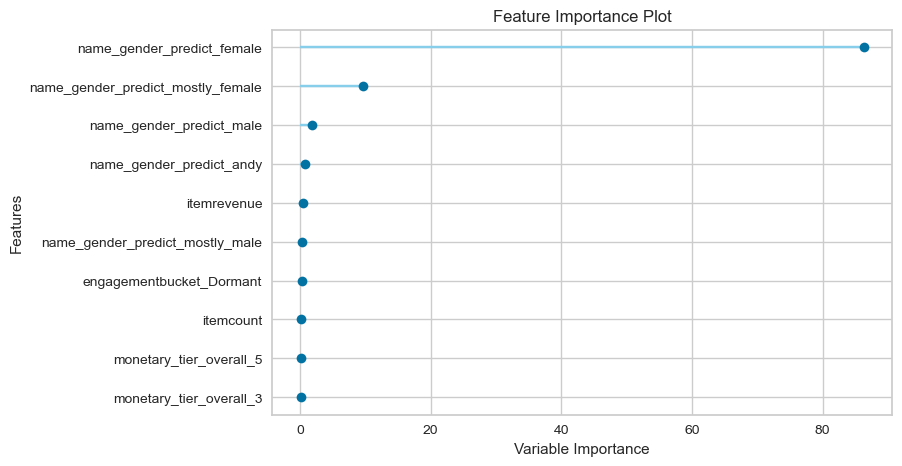

In [41]:
plot_model(best_model, plot="feature")

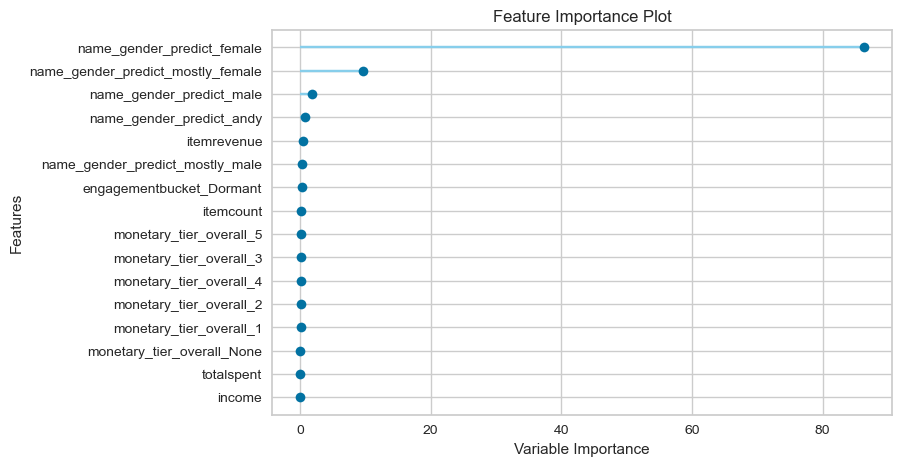

In [42]:
plot_model(best_model, plot="feature_all")

In [43]:
predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9517,0.9687,0.6453,0.9366,0.9439,0.8947,0.8954


,income,itemcount,itemrevenue,totalspent,monetary_tier_overall_1,monetary_tier_overall_2,monetary_tier_overall_3,monetary_tier_overall_4,monetary_tier_overall_5,monetary_tier_overall_None,engagementbucket_Dormant,name_gender_predict_andy,name_gender_predict_female,name_gender_predict_male,name_gender_predict_mostly_female,name_gender_predict_mostly_male,gender,Label,Score
0,0.0,0.0,67.54229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,male,male,0.9790
1,0.0,0.0,67.54229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,female,female,0.9543
2,0.0,0.0,67.54229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,male,male,0.9584
3,0.0,0.0,67.54229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,male,male,0.9790
4,0.0,0.0,67.54229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,male,male,0.9790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467976,0.0,0.0,67.54229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,male,male,0.9790
467977,0.0,0.0,67.54229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,male,male,0.9790
467978,0.0,0.0,67.54229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,female,female,0.9543
467979,0.0,0.0,67.54229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,male,male,0.9790


# Inference Tests

The value of unknowns shows that the inherent bias of the model is roughly 20% skew to male. If there is no name (unknown name) it will predict male with 70% confidence.

unknown	male	0.702979

In [44]:
query = """
select cc.gender, cc.dimcustomermasterid, cc.lkupclientid, cc.namefirst, cc.income, cc.education, cc.occupation, cc.monetary_tier_overall, cc.engagementbucket, cc.loyaltypointbalance, cc.isgamer, cm.itemdescription, cm.itemcount, cm.itemrevenue, ccon.purchasecount, ccon.totalspent
from dw.cohortcustomer cc 
	left join dw.cohortmerch cm on cc.dimcustomermasterid = cm.dimcustomermasterid 
	left join dw.cohortconcession ccon on cc.dimcustomermasterid = ccon.dimcustomermasterid 
where cc.gender is null;
"""

cluster = "prod-app"
database = "stlrtrailblazers"

In [45]:
conn = redshift_tools.get_redshift_connection(cluster, database)

cur = conn.cursor()
cur.execute(query)

data = cur.fetchall()

cols = [row[0] for row in cur.description]
df = pd.DataFrame(data=data, columns=cols)

conn.close()

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


In [46]:
inference_name = df

In [47]:
inference_name.shape

(1356061, 16)

### Pre-Processing

We will preprocess the data, so we can have a predicted score of their gender and clean other data.

In [48]:
gdectect = gender.Detector()

In [49]:
inference_name["name_gender_predict"] = inference_name["namefirst"].apply(gdectect.get_gender)

In [50]:
inference_name.name_gender_predict.value_counts()

male             537956
female           419245
unknown          256731
mostly_male       66460
mostly_female     57582
andy              18087
Name: name_gender_predict, dtype: int64

In [51]:
inference_name["totalspent"] = inference_name["totalspent"].fillna(0)

In [52]:
inference_name["itemcount"] = inference_name["itemcount"].fillna(0)

In [53]:
inference_name = inference_name.drop(columns=["gender"], axis=1)

In [55]:
name_results = predict_model(best_model, inference_name)

In [56]:
name_results.groupby(["name_gender_predict", "Label"]).agg({"Score":"mean"})

Score
name_gender_predict Label           
andy                female  0.515500
                    male    0.619680
female              female  0.952289
male                male    0.978038
mostly_female       female  0.657888
mostly_male         male    0.956830
unknown             female  0.515500
                    male    0.621922

# Train with Smote

The results of the compare model below, shows that smote does not help improve over non-smote implementation

In [57]:
# setup(
#     data=df_temp,
#     target='gender',
#     train_size=0.85,
#     data_split_shuffle=True,
#     silent=True,
#     verbose=False,
#     fix_imbalance=True,
#     ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription"],
#     numeric_features=["totalspent"]
# )

In [58]:
# smote_model_matrix = compare_models(
#     fold=2,
#     include= ["lightgbm", "catboost", "rf", "svm", "xgboost"]
# )

# Train without Name Data

We wanted to determine if name_gender_predict is the most important factor in predicting a persons gender.

The result of this test is that the accuracy is worse than randomly guessing without the name_gender_predict feature.

In [ ]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=["dimcustomermasterid", "lkupclientid", "namefirst", "itemdescription", "name_gender_predict"],
    numeric_features=["totalspent"]
)

In [60]:
smote_model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost", "dummy"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6550,0.5126,0.3366,0.5982,0.5285,0.0122,0.0416,18.4950
xgboost,Extreme Gradient Boosting,0.6550,0.5124,0.3366,0.5990,0.5285,0.0123,0.0419,79.3450
catboost,CatBoost Classifier,0.6549,0.5125,0.3368,0.5972,0.5292,0.0129,0.0423,46.5000
rf,Random Forest Classifier,0.6547,0.5109,0.3367,0.5945,0.5293,0.0128,0.0410,6.7650
dummy,Dummy Classifier,0.6545,0.5000,0.3333,0.4283,0.5178,0.0000,0.0000,1.4150
svm,SVM - Linear Kernel,0.6543,0.0000,0.3334,0.5512,0.5180,0.0001,0.0019,14.8300


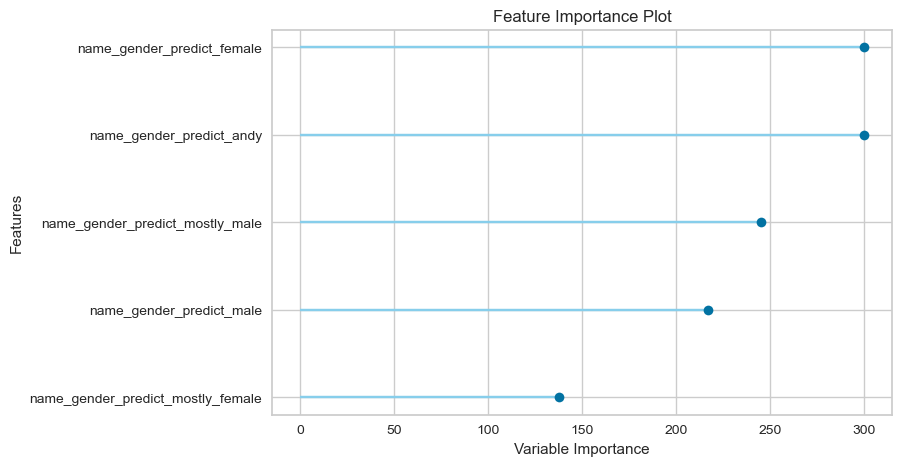

In [76]:
plot_model(smote_model_matrix, plot="feature")

# Train with only name_gender_predict (Python Gender Package)


In [61]:
setup(
    data=df_temp,
    target='gender',
    train_size=0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=['dimcustomermasterid', 'lkupclientid', 'namefirst', 'income',
       'education', 'occupation', 'monetary_tier_overall', 'engagementbucket',
       'loyaltypointbalance', 'isgamer', 'itemdescription', 'itemcount',
       'itemrevenue', 'purchasecount', 'totalspent']
)

(         name_gender_predict_andy  name_gender_predict_female  \
 1090687                       0.0                         0.0   
 308696                        0.0                         0.0   
 2924301                       0.0                         0.0   
 2350442                       0.0                         0.0   
 1748389                       0.0                         0.0   
 ...                           ...                         ...   
 1385660                       0.0                         0.0   
 866903                        0.0                         0.0   
 1473233                       0.0                         0.0   
 1453269                       0.0                         0.0   
 1164601                       0.0                         1.0   
 
          name_gender_predict_male  name_gender_predict_mostly_female  \
 1090687                       1.0                                0.0   
 308696                        1.0                          

In [62]:
smote_model_matrix = compare_models(
    fold=2,
    include= ["lightgbm", "catboost", "rf", "svm", "xgboost", "dummy", "lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9515,0.9676,0.6452,0.9364,0.9437,0.8943,0.8950,10.2900
catboost,CatBoost Classifier,0.9515,0.9676,0.6452,0.9364,0.9437,0.8943,0.8950,44.4150
rf,Random Forest Classifier,0.9515,0.9676,0.6452,0.9364,0.9437,0.8943,0.8950,5.5550
svm,SVM - Linear Kernel,0.9515,0.0000,0.6452,0.9364,0.9437,0.8943,0.8950,2.4950
xgboost,Extreme Gradient Boosting,0.9515,0.9676,0.6452,0.9364,0.9437,0.8943,0.8950,30.5250
lr,Logistic Regression,0.9515,0.9676,0.6452,0.9364,0.9437,0.8943,0.8950,3.7300
dummy,Dummy Classifier,0.6546,0.5000,0.3333,0.4285,0.5179,0.0000,0.0000,2.3650


The above result shows the results of only using the python package to get the probability of a gender, while the table below shows the full model with the features selected for this experiment.

Comparing these two shows that the added features marginally increases the accuracy.

Note, this is just for portland trail blazers, largely this is the same for all other teams tested.

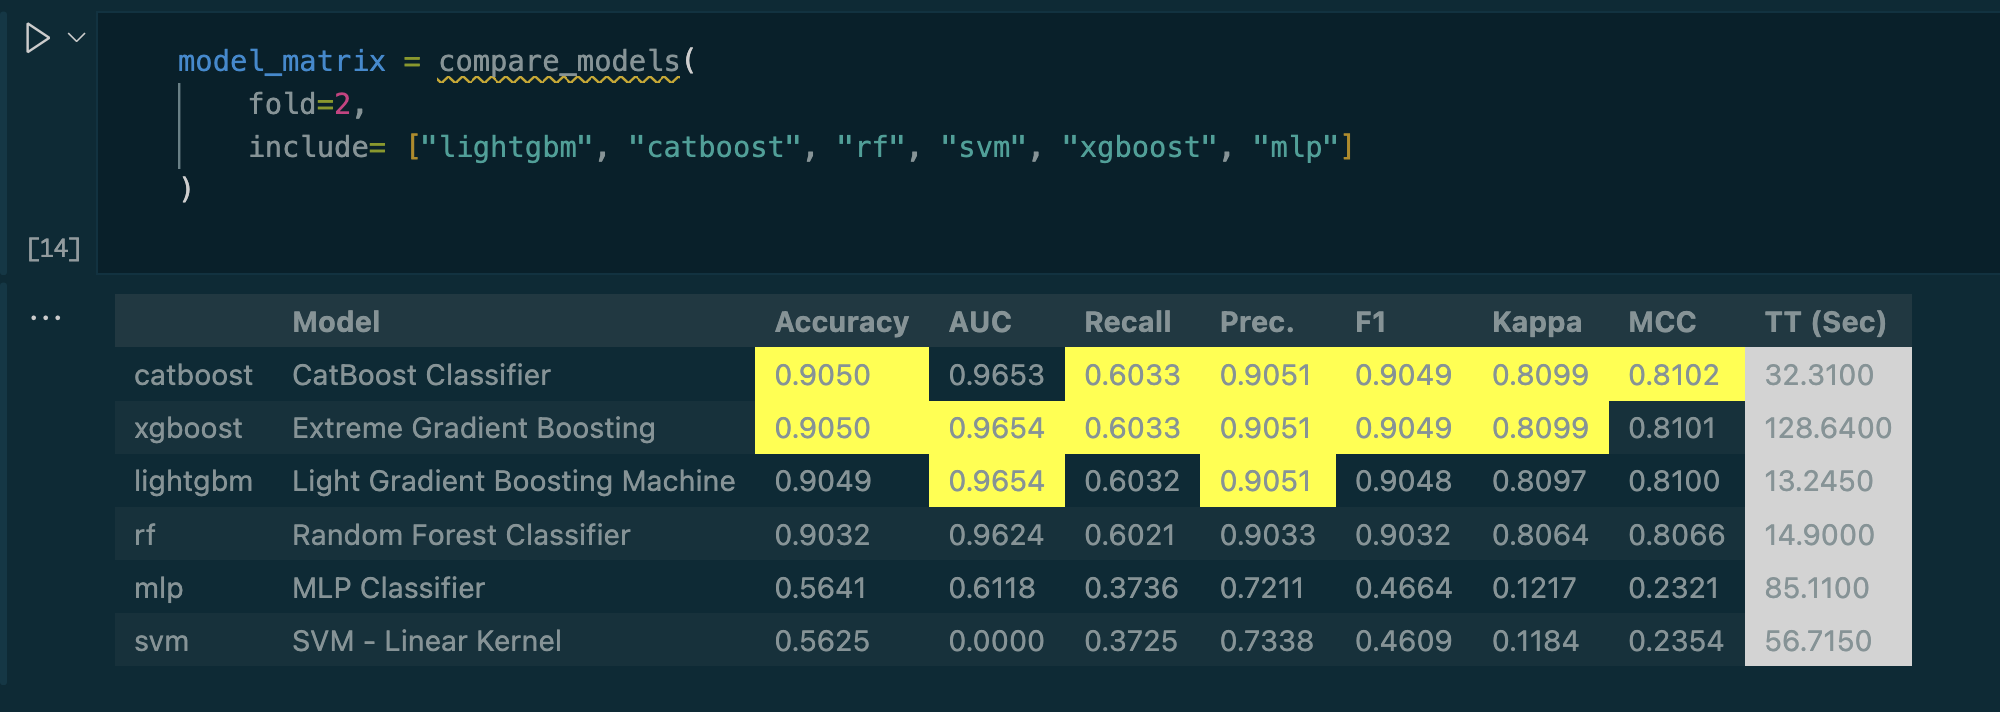

In [63]:
final_model = finalize_model(smote_model_matrix)

/Users/petermorrison/miniforge3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/petermorrison/miniforge3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/petermorrison/miniforge3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

In [64]:
# List of female first names
first_names_female = ["Emma", "Olivia", "Ava", "Isabella", "Sophia", "Charlotte", "Mia", "Amelia", "Harper", "Evelyn", "Abigail", "Emily", "Elizabeth", "Mila", "Ella", "Avery", "Sofia", "Camila", "Aria", "Scarlett", "Victoria", "Madison", "Luna", "Grace", "Chloe", "Penelope", "Layla", "Riley", "Zoey", "Nora", "Lily", "Eleanor", "Hannah", "Lillian", "Addison", "Aubrey", "Ellie", "Stella", "Natalie", "Zoe", "Leah", "Hazel", "Violet", "Aurora", "Savannah", "Audrey", "Brooklyn", "Bella", "Claire", "Skylar", "Lucy", "Paisley", "Everly", "Anna", "Caroline", "Nova", "Genesis", "Emilia", "Kennedy", "Samantha", "Maya", "Willow", "Kinsley", "Naomi", "Aaliyah", "Elena", "Ariana", "Sarah", "Allison", "Gabriella", "Alice", "Madelyn", "Cora", "Ruby", "Eva", "Serenity", "Autumn", "Adeline", "Hailey", "Gianna", "Valentina", "Isla", "Eliana", "Quinn", "Nevaeh", "Ivy", "Sadie", "Piper", "Lydia", "Alexa", "Josephine", "Emery", "Julia", "Delilah", "Arianna", "Vivian", "Kaylee"]

# List of male first names
first_names_male = ["Liam", "Noah", "Oliver", "Elijah", "William", "James", "Benjamin", "Lucas", "Henry", "Alexander", "Mason", "Michael", "Ethan", "Daniel", "Jacob", "Logan", "Jackson", "Levi", "Sebastian", "Mateo", "Jack", "Owen", "Theodore", "Aiden", "Samuel", "Matthew", "Leo", "David", "Joseph", "Caleb", "Isaac", "Wyatt", "John", "Lincoln", "Ezra", "Grayson", "Luke", "Cameron", "Connor", "Eli", "Nathan", "Nicholas", "Julian", "Aaron", "Adam", "Robert", "Zachary", "Thomas", "Nolan", "Ian", "Evan", "Cooper", "Miles", "Carson", "Gabriel", "Anthony", "Harrison", "Dominic", "Hunter", "David", "Cole", "Colton", "Oscar", "Leo", "Bryson", "Vincent", "Kai", "Caden", "Jayden", "Maxwell", "Silas", "Weston", "Micah", "Declan", "Jaxson", "Ryder", "August", "River", "Emmett", "Brandon", "Beau", "Brayden", "George", "Asher"]

## Testing for female names

In [65]:
female_df = pd.DataFrame(first_names_female, columns=['namefirst'])

In [66]:
female_df.shape

(97, 1)

In [67]:
female_df["name_gender_predict"] = female_df["namefirst"].apply(gdectect.get_gender)

In [68]:
name_results = predict_model(final_model, female_df)

In [69]:
name_results.groupby("Label").count()

,namefirst,name_gender_predict,Score
Label,,,
female,86,86,86
male,11,11,11


In [70]:
name_results[name_results["Label"] == "male"]

,namefirst,name_gender_predict,Label,Score
8,Harper,male,male,0.9785
15,Avery,andy,male,0.6297
27,Riley,mostly_male,male,0.9571
34,Addison,andy,male,0.6297
35,Aubrey,andy,male,0.6297
49,Skylar,andy,male,0.6297
51,Paisley,unknown,male,0.6297
52,Everly,unknown,male,0.6297
62,Kinsley,unknown,male,0.6297
83,Quinn,mostly_male,male,0.9571


## Now testing for male names

In [71]:
male_df = pd.DataFrame(first_names_male, columns=['namefirst'])
male_df.shape

(84, 1)

In [72]:
male_df["name_gender_predict"] = male_df["namefirst"].apply(gdectect.get_gender)

In [73]:
name_results = predict_model(final_model, male_df)

In [74]:
name_results.groupby("Label").count()

,namefirst,name_gender_predict,Score
Label,,,
female,1,1,1
male,83,83,83


In [75]:
name_results[name_results["Label"] == "female"]

,namefirst,name_gender_predict,Label,Score
39,Eli,female,female,0.9544
